In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [95]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [96]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [97]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [98]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [99]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [100]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


<h4>Getting party id's from keys to compare vendors</h4>

In [101]:
# import fnmatch

# def get_matching_keys(pattern, keys):
#     matching_keys = fnmatch.filter(keys, pattern)
#     return matching_keys

# # Loop for old_df
# for key in old_df:
#     split_key = key.split('_', 6)
#     key_without_partyid = '_'.join(split_key[:-1])
#     print(f"Key: {key_without_partyid}")

#     # get matching keys in old data
#     matching_keys_old = get_matching_keys(key_without_partyid + '*', df_ids1)
#     print("Matching keys in old data:")
#     for matching_key in matching_keys_old:
#         party_id, num_rows = get_party_id(matching_key, filtered_dataframe1)
#         print(f"For key {matching_key}, Party_ID is {party_id} and number of rows is {num_rows}")
#     print("\n")
    
# # Loop for new_df
# for key in new_df:
#     split_key = key.split('_', 6)
#     key_without_partyid = '_'.join(split_key[:-1])
#     print(f"Key: {key_without_partyid}")

#     # get matching keys in new data
#     matching_keys_new = get_matching_keys(key_without_partyid + '*', df_ids2)
#     print("\nMatching keys in new data:")
#     for matching_key in matching_keys_new:
#         party_id, num_rows = get_party_id(matching_key, filtered_dataframe2)
#         print(f"For key {matching_key}, Party_ID is {party_id} and number of rows is {num_rows}")
#     print("\n")

In [102]:
def getKeysWithMoreThan500Rows(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Iterate over the key_row_counts dictionary
    for key, row_count in key_row_counts.items():
        if row_count > 500:
            print(f"Number of rows in {key}: {row_count}")
            keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

print('Old Dataset Keys with more than 500 rows:')
old_df = getKeysWithMoreThan800Rows(filtered_dataframe1)
print(f"Total of: {len(old_df)} ")
print('\n')

print('New Dataset Keys with more than 500 rows:')
new_df = getKeysWithMoreThan800Rows(filtered_dataframe2)
print(f"Total of: {len(new_df)} ")


Old Dataset Keys with more than 500 rows:
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_AUCKLAND_Size_40_Type_HC NOR_PartyID_01005136: 865
Number of rows in Port_BANGKOK_Size_40_Type_HC_PartyID_01002799: 505
Number of rows in Port_BRISBANE_Size_40_Type_HC_PartyID_01002776: 799
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052
Number of rows in Port_FELIXSTOWE_Size_40_Type_HC_PartyID_01002303: 558
Number of rows in Port_FREMANTLE_Size_40_Type_HC_PartyID_01002777: 814
Number of rows in Port_HAIPHONG_Size_40_Type_HC_PartyID_010005255: 646
Number of rows in Port_HOCHIMINH CAT LAI,VIETNAM_Size_40_Type_HC_PartyID_010005256: 915
Number of rows in Port_LAEM CHABANG_Size_40_Type_HC_PartyID_01002799: 517
Number of rows in Port_LYTTELTON_Size_40_Type_HC_PartyID_01005136: 514
Number of rows in Port_MADRAS/CHENNAI_Size_40_Type_HC_PartyID_010006979: 593
N

In [103]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[15]]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[new_df[15]]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1320,ECS010230100302,010000357415,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-11,40,HC,1200.0
1321,ECS010230100303,010000380481,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-16,40,HC,1200.0
1323,ECS010230100304,010000392586,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1322,ECS010230100304,010000390964,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1324,ECS010230100304,010000399293,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1325 non-null   object        
 1   CNTR_ID     1325 non-null   object        
 2   POD_ID      1325 non-null   object        
 3   ETD_POL_D   1325 non-null   object        
 4   PARTY_ID    1325 non-null   object        
 5   PARTY_NAME  1325 non-null   object        
 6   POD         1325 non-null   datetime64[ns]
 7   CNTR_SIZE   1325 non-null   object        
 8   CNTR_TYPE   1325 non-null   object        
 9   RATE        1325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 113.9+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1336,ECS010230300518,010000531211,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1337,ECS010230300518,010000509487,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1338,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
1339,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
1340,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1341 non-null   object        
 1   CNTR_ID     1341 non-null   object        
 2   POD_ID      1341 non-null   object        
 3   ETD_POL_D   1341 non-null   object        
 4   PARTY_ID    1341 non-null   object        
 5   PARTY_NAME  1341 non-null   object        
 6   POD         1341 non-null   datetime64[ns]
 7   CNTR_SIZE   1341 non-null   object        
 8   CNTR_TYPE   1341 non-null   object        
 9   RATE        1341 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 115.2+ KB


<h4>Interpolate missing values in between dates</h4>

In [104]:
# Interpolate using spline interpolation

# Remove duplicated dates and cost rows
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Remove features that are not important
sel_feat = ['POD','RATE']
sel_df = sel_df[sel_feat]

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, sel_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='spline', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(2)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-23,1200.0
1,2005-07-24,1200.0
2,2005-07-25,1200.0
3,2005-07-26,1200.0
4,2005-07-27,1200.0


,POD,RATE
6441,2023-02-20,1199.99
6442,2023-02-21,1199.99
6443,2023-02-22,1199.99
6444,2023-02-23,1199.99
6445,2023-02-24,1200.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6446 entries, 0 to 6445
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6446 non-null   datetime64[ns]
 1   RATE    6446 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.1 KB


<h4>Group by week</h4>

In [105]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')
 
# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_17952\2508895437.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_17952\2508895437.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_17952\2508895437.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_17952\2508895437.py:42: FutureWarning: The frame.append method is deprecated and will be r

,YearMonthWeek,Rate
0,2005-07-18,1200.000000
1,2005-07-25,1198.317143
2,2005-08-01,1141.187143
3,2005-08-08,1058.858571
4,2005-08-15,1113.534286
5,2005-08-22,1165.990000
6,2005-08-29,1126.380000
7,2005-09-05,1086.760000
8,2005-09-12,1047.148571
9,2005-09-19,1007.530000


,YearMonthWeek,Rate
903,2022-11-07,2999.700000
904,2022-11-14,4444.786250
905,2022-11-21,2969.680000
906,2022-11-28,2861.660000
907,2022-12-05,2560.000000
908,2022-12-12,2400.010000
909,2022-12-19,2399.990000
910,2022-12-26,2307.690000
911,2023-01-02,2092.312857
912,2023-01-09,1999.962857


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [106]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200328,010000409869,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-02,40,HC,1000.0
1,ECS010230200329,010000419018,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-10,40,HC,1000.0
2,ECS010230200330,010000427048,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-16,40,HC,1000.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
14,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
15,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


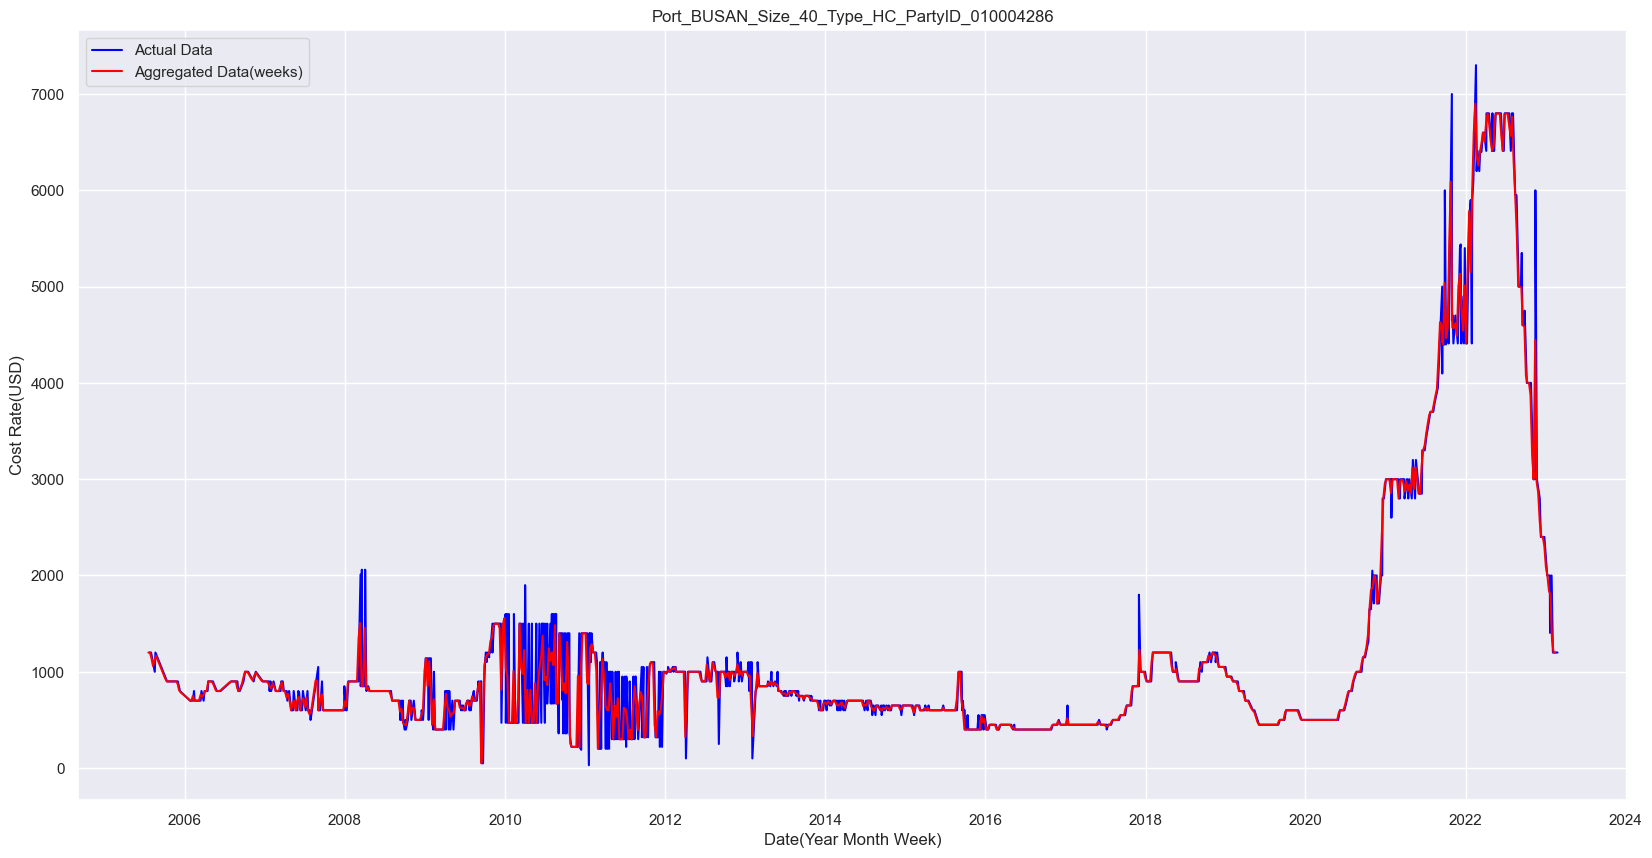

In [107]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [108]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>LSTM Regression<h4>

In [109]:
from keras.layers import Dropout

# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dropout(0.3))  # 20% dropout
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=True))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(8, activation='tanh', return_sequences=True))
    model.add(LSTM(8, activation='tanh')) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=64, verbose=2, validation_data=(testX, testY))
    return model, history

def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 1, 64)             17920     
                                                                 
 dropout_6 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_49 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_50 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_51 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_52 (LSTM)              (None, 1, 16)             3136      
                                                                 
 lstm_53 (LSTM)             

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

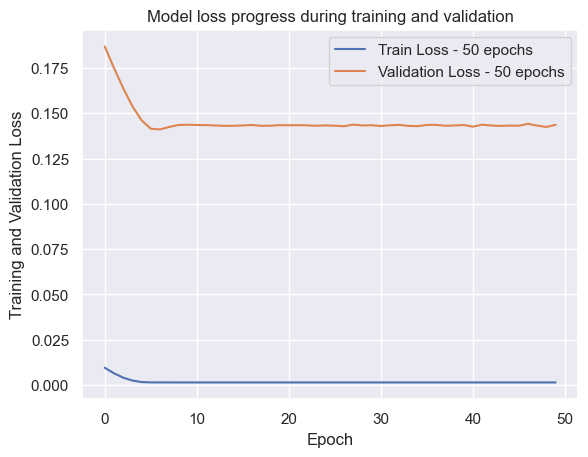

9/9 [==============================] - 0s 4ms/step
Train Score: 249.63 RMSE for 50 epochs
Test Score: 2595.82 RMSE for 50 epochs
Training for 100 epochs...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 1, 64)             17920     
                                                                 
 dropout_7 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_57 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_58 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_59 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_60 (LSTM)              (

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

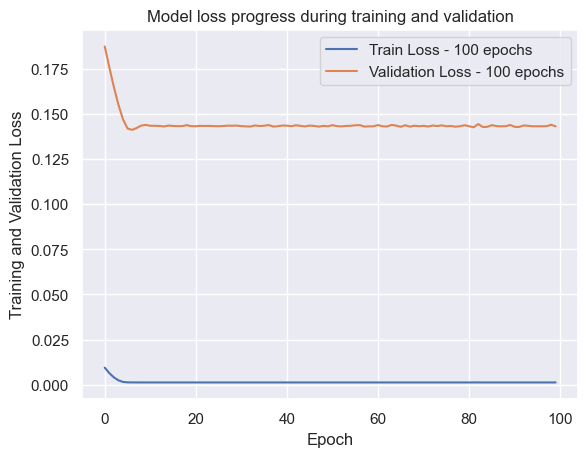

9/9 [==============================] - 0s 4ms/step
Train Score: 249.54 RMSE for 100 epochs
Test Score: 2590.46 RMSE for 100 epochs
Training for 300 epochs...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 1, 64)             17920     
                                                                 
 dropout_8 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_65 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_66 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_67 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_68 (LSTM)             

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

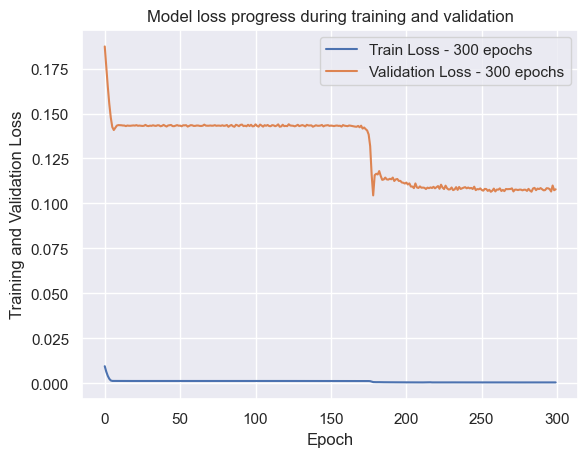

9/9 [==============================] - 0s 4ms/step
Train Score: 155.65 RMSE for 300 epochs
Test Score: 2249.81 RMSE for 300 epochs
     Train RMSE    Test RMSE
50   249.631550  2595.819655
100  249.543804  2590.459044
300  155.652267  2249.812676


In [110]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(agg_df['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [50, 100, 300]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)
